In [100]:
from neurosynth.base.dataset import Dataset
from owlready2 import get_ontology
from neurosynth.analysis import meta
import nibabel as nib
import nilearn as nil
from nilearn import plotting
from neurolang import frontend as fe

import warnings
warnings.filterwarnings('ignore')

In [101]:
relations = [
    ('l_g_and_s_frontomargin','Left frontomarginal gyrus'),
    ('l_g_and_s_occipital_inf','Left inferior occipital gyrus'),
    ('l_g_and_s_paracentral','Left paracentral lobule'),
    ('l_g_and_s_subcentral','Left subcentral gyrus'),
    ('l_g_and_s_transv_frontopol','Left superior transverse frontopolar gyrus'),
    ('l_g_and_s_cingul_ant','Left anterior cingulate gyrus'),
    ('l_g_and_s_cingul_mid_ant','Left anterior middle cingulate gyrus'),
    ('l_g_and_s_cingul_mid_post','Left posterior middle cingulate gyrus'),
    ('l_g_cingul_post_dorsal','Dorsal segment of left posterior middle cingulate gyrus'),
    ('l_g_cingul_post_ventral','Ventral segment of left posterior middle cingulate gyrus'),
    ('l_g_cuneus','Left cuneus'),
    ('l_g_front_inf_opercular','Opercular part of left inferior frontal gyrus'),
    ('l_g_front_inf_orbital','Orbital part of left inferior frontal gyrus'),
    ('l_g_front_inf_triangul','Triangular part of left inferior frontal gyrus'),
    ('l_g_front_middle','Left middle frontal gyrus'),
    ('l_g_front_sup','Left superior frontal gyrus'),
    ('l_g_ins_lg_and_s_cent_ins','Left central insular sulcus'),
    ('l_g_ins_lg_and_s_cent_ins','Left long insular gyrus'),
    ('l_g_insular_short','Short insular gyrus'),
    ('l_g_occipital_middleLeft', 'lateral occipital gyru'),
    ('l_g_occipital_sup','Left superior occipital gyrus'),
    ('l_g_oc_temp_lat_fusifor','Left fusiform gyrus'),
    ('l_g_oc_temp_med_lingual','Left lingual gyrus'),
    ('l_g_oc_temp_med_parahip','Left parahippocampal gyrus'),
    ('l_g_orbital','Left orbital gyrus'),
    ('l_g_pariet_inf_angular','Left angular gyrus'),
    ('l_g_pariet_inf_supramar','Left supramarginal gyrus'),
    ('l_g_parietal_sup','Left superior parietal lobule'),
    ('l_g_postcentral','Left postcentral gyrus'),
    ('l_g_precentral','Left precentral gyrus'),
    ('l_g_precuneus','Left precuneus'),
    ('l_g_rectus','Left straight gyrus'),
    ('l_g_subcallosal','Left paraterminal gyrus'),
    ('l_g_temp_sup_g_t_transv','Left transverse temporal gyrus'),
    ('l_g_temp_sup_lateral','Left superior temporal gyrus'),
    ('l_g_temp_sup_plan_polar','Left superior temporal gyrus'),
    ('l_g_temp_sup_plan_tempo','Left superior temporal gyrus'),
    ('l_g_temporal_inf','Left inferior temporal gyrus'),
    ('l_g_temporal_middle','Left middle temporal gyrus'),
    ('l_lat_fis_ant_horizont','Anterior horizontal limb of left lateral sulcus'),
    ('l_lat_fis_ant_vertical','Anterior ascending limb of left lateral sulcus'),
    ('l_lat_fis_post','Posterior ascending limb of left lateral sulcus'),
    ('l_lat_fis_post','Left lateral sulcus'),
    ('l_pole_occipital','Left occipital pole'),
    ('l_pole_temporal','Left temporal pole'),
    ('l_s_calcarine','Left Calcarine sulcus'),
    ('l_s_central','Left central sulcus'),
    ('l_s_cingul_marginalis','Left marginal sulcus'),
    ('l_s_circular_insula_ant','Circular sulcus of left insula'),
    ('l_s_circular_insula_inf','Circular sulcus of left insula'),
    ('l_s_circular_insula_sup','Circular sulcus of left insula'),
    ('l_s_collat_transv_ant','Left collateral sulcus'),
    ('l_s_collat_transv_post','Left collateral sulcus'),
    ('l_s_front_inf','Left inferior frontal sulcus'),
    ('l_s_front_sup','Left superior frontal sulcus'),
    ('l_s_intrapariet_and_p_trans','Left intraparietal sulcus'),
    ('l_s_oc_middle_and_lunatus','Left lunate sulcus'),
    ('l_s_oc_sup_and_transversal','Left transverse occipital sulcus'),
    ('l_s_occipital_ant','Left anterior occipital sulcus'),
    ('l_s_oc_temp_lat','Left occipitotemporal sulcus'),
    ('l_s_oc_temp_med_and_lingual','Left intralingual sulcus'),
    ('l_s_orbital_lateral','Left orbital sulcus'),
    ('l_s_orbital_med_olfact','Left olfactory sulcus'),
    ('l_s_orbital_h_shaped','Left transverse orbital sulcus'),
    ('l_s_orbital_h_shaped','Left orbital sulcus'),
    ('l_s_parieto_occipital','Left parieto-occipital sulcus'),
    ('l_s_pericallosal','Left callosal sulcus'),
    ('l_s_postcentral','Left postcentral sulcus'),
    ('l_s_precentral_inf_part','Left precentral sulcus'),
    ('l_s_precentral_sup_part','Left precentral sulcus'),
    ('l_s_suborbital','Left fronto-orbital sulcus'),
    ('l_s_subparietal','Left subparietal sulcus'),
    ('l_s_temporal_inf','Left inferior temporal sulcus'),
    ('l_s_temporal_sup','Left superior temporal sulcus'),
    ('l_s_temporal_transverse','Left transverse temporal sulcus'),
    ('r_g_and_s_frontomargin','Right frontomarginal gyrus'),
    ('r_g_and_s_occipital_inf','Right inferior occipital gyrus'),
    ('r_g_and_s_paracentral','Right paracentral lobule'),
    ('r_g_and_s_subcentral','Right subcentral gyrus'),
    ('r_g_and_s_transv_frontopol','Right superior transverse frontopolar gyrus'),
    ('r_g_and_s_cingul_ant','Right anterior cingulate gyrus'),
    ('r_g_and_s_cingul_mid_ant','Right anterior middle cingulate gyrus'),
    ('r_g_and_s_cingul_mid_post','Right posterior middle cingulate gyrus'),
    ('r_g_cingul_post_dorsal','Dorsal segment of right posterior middle cingulate gyrus'),
    ('r_g_cingul_post_ventral','Ventral segment of right posterior middle cingulate gyrus'),
    ('r_g_cuneus','Right cuneus'),
    ('r_g_front_inf_opercular','Opercular part of right inferior frontal gyrus'),
    ('r_g_front_inf_orbital','Orbital part of right inferior frontal gyrus'),
    ('r_g_front_inf_triangul','Triangular part of right inferior frontal gyrus'),
    ('r_g_front_middle','Right middle frontal gyrus'),
    ('r_g_front_sup','Right superior frontal gyrus'),
    ('r_g_ins_lg_and_s_cent_ins','Right central insular sulcus'),
    ('r_g_ins_lg_and_s_cent_ins','Right long insular gyrus'),
    ('r_g_insular_short','Right short insular gyrus'),
    ('r_g_occipital_middle','Right lateral occipital gyrus'),
    ('r_g_occipital_sup','Right superior occipital gyrus'),
    ('r_g_oc_temp_lat_fusifor','Right fusiform gyrus'),
    ('r_g_oc_temp_med_lingual','Right lingual gyrus'),
    ('r_g_oc_temp_med_parahip','Right parahippocampal gyrus'),
    ('r_g_orbital','Right orbital gyrus'),
    ('r_g_pariet_inf_angular','Right angular gyrus'),
    ('r_g_pariet_inf_supramar','Right supramarginal gyrus'),
    ('r_g_parietal_sup','Right superior parietal lobule'),
    ('r_g_postcentral','Right postcentral gyrus'),
    ('r_g_precentral','Right precentral gyrus'),
    ('r_g_precuneus','Right precuneus'),
    ('r_g_rectus','Right straight gyrus'),
    ('r_g_subcallosal','Right paraterminal gyrus'),
    ('r_g_temp_sup_g_t_transv','Right transverse temporal gyrus'),
    ('r_g_temp_sup_lateral','Right superior temporal gyrus'),
    ('r_g_temp_sup_plan_polar','Right superior temporal gyrus'),
    ('r_g_temp_sup_plan_tempo','Right superior temporal gyrus'),
    ('r_g_temporal_inf','Right inferior temporal gyrus'),
    ('r_g_temporal_middle','Right middle temporal gyrus'),
    ('r_lat_fis_ant_horizont','Anterior horizontal limb of right lateral sulcus'),
    ('r_lat_fis_ant_vertical','Anterior ascending limb of right lateral sulcus'),
    ('r_lat_fis_post','Right lateral sulcus'),
    ('r_lat_fis_post','Posterior ascending limb of right lateral sulcus'),
    ('r_pole_occipital','Right occipital pole'),
    ('r_pole_temporal','Right temporal pole'),
    ('r_s_calcarine','Right Calcarine sulcus'),
    ('r_s_central','Right central sulcus'),
    ('r_s_cingul_marginalis','Right marginal sulcus'),
    ('r_s_circular_insula_ant','Circular sulcus of Right insula'),
    ('r_s_circular_insula_inf','Circular sulcus of Right insula'),
    ('r_s_circular_insula_sup','Circular sulcus of Right insula'),
    ('r_s_collat_transv_ant','Right collateral sulcus'),
    ('r_s_collat_transv_post','Right collateral sulcus'),
    ('r_s_front_inf','Right inferior frontal sulcus'),
    ('r_s_front_sup','Right superior frontal sulcus'),
    ('r_s_intrapariet_and_p_trans','Right intraparietal sulcus'),
    ('r_s_oc_middle_and_lunatus','Right lunate sulcus'),
    ('r_s_oc_sup_and_transversal','Right transverse occipital sulcus'),
    ('r_s_occipital_ant','Right anterior occipital sulcus'),
    ('r_s_oc_temp_lat','Right occipitotemporal sulcus'),
    ('r_s_oc_temp_med_and_lingual','Right intralingual sulcus'),
    ('r_s_orbital_lateral','Right orbital sulcus'),
    ('r_s_orbital_med_olfact','Right olfactory sulcus'),
    ('r_s_orbital_h_shaped','Right orbital sulcus'),
    ('r_s_orbital_h_shaped','Right transverse orbital sulcus'),
    ('r_s_parieto_occipital','Right parieto-occipital sulcus'),
    ('r_s_pericallosal','Right callosal sulcus'),
    ('r_s_postcentral','Right postcentral sulcus'),
    ('r_s_precentral_inf_part','Right precentral sulcus'),
    ('r_s_precentral_sup_part','Right precentral sulcus'),
    ('r_s_suborbital','Right fronto-orbital sulcus'),
    ('r_s_subparietal','Right subparietal sulcus'),
    ('r_s_temporal_inf','Right inferior temporal sulcus'),
    ('r_s_temporal_sup','Right superior temporal sulcus'),
    ('r_s_temporal_transverse','Right transverse temporal sulcus'),
]

In [102]:
onto = get_ontology('./fma.owl')
onto.load()

def get_nodes(onto, main_label, labels=[]):
    for main in onto.search(label = main_label):
        subs = list(main.subclasses())
        while subs:
            subc = subs.pop(0)
            labels.append(subc.label[0])
            subs = subs + list(subc.subclasses())
    labels = list(dict.fromkeys(labels))
    return labels

def get_subclasses(onto, main_label, apply=None):
    subclasses = dict()
    for main in onto.search(label = main_label):
        subs = [main]
        while subs:
            subc = subs.pop(0)
            temp = list(subc.subclasses())
            if len(temp) > 0:
                subclasses[subc.label[0]] = [e.label[0] for e in temp]
                subs = subs + temp
    if apply is not None:
        subclasses = apply(subclasses)
    return subclasses

def parse_isSub(subc):
    subclass = []
    for k, v in subc.items():
        for elem in v:
            subclass.append((k, elem))
    return subclass

def get_synonyms(onto, main_label, apply=None):
    synonyms = dict()
    for main in onto.search(label = main_label):
        subs = [main]
        while subs:
            subc = subs.pop(0)
            temp = list(subc.subclasses())
            syn = subc.synonym
            if len(syn) > 0:
                synonyms[subc.label[0]] = syn
            subs = subs + temp
    if apply is not None:
        synonyms = apply(synonyms)
    return synonyms

def parse_isSyn(syn):
    syns = []
    for k, v in syn.items():
        for elem in v:
            syns.append((k, elem))
            syns.append((elem, k))
    return syns

nl = fe.NeurolangDL()

nodes = get_nodes(onto, 'Segment of brain')
subc = get_subclasses(onto, 'Segment of brain', apply=parse_isSub)
syn = get_synonyms(onto, 'Segment of brain', apply=parse_isSyn)

nl.add_tuple_set(
    ((str(e),) for e in nodes),
    name='nodes'
);

nl.add_tuple_set(
    ((str(e1), str(e2),) for e1, e2 in subc),
    name='subclasses'
);

nl.add_tuple_set(
    ((str(e1), str(e2),) for e1, e2 in syn),
    name='synonyms'
);

In [103]:
import nilearn
import nibabel as nib
from nilearn import datasets
from neurolang import regions
import numpy as np

from neurolang import expressions
from neurolang import solver_datalog_naive as sdb
from neurolang import solver_datalog_extensional_db
from neurolang import expression_walker as ew
from neurolang import datalog_chase as dc

C_ = expressions.Constant
S_ = expressions.Symbol
Imp_ = sdb.Implication
Fact_ = sdb.Fact
Eb_ = expressions.ExpressionBlock


destrieux_dataset = datasets.fetch_atlas_destrieux_2009()
destrieux_map = nib.load(destrieux_dataset['maps'])

d = []
for label_number, name in destrieux_dataset['labels']:
    if label_number == 0:
        continue
    name = name.decode()
    region = nl.create_region(destrieux_map, label=label_number)
    if region is None:
        continue
    name = name.replace('-', '_').replace(' ', '_')
    d.append((name.lower(), region))

nl.add_tuple_set(d, name='destrieux_regions');

In [104]:
nl.add_tuple_set(
    ((e1, e2,) for e1, e2 in relations),
    name='relations'
);

In [105]:
x = nl.new_symbol(name='x')
y = nl.new_symbol(name='y')
z = nl.new_symbol(name='z')
destrieux = nl.new_symbol(name='destrieux')
relation = nl.new_symbol(name='relation')
val = nl.new_symbol(name='val')
isSub = nl.new_symbol(name='isSub')
isSyn = nl.new_symbol(name='isSyn')

query1 = nl.query(val(x), nl.symbols.nodes(x))
query2 = nl.query(isSyn(x, y), nl.symbols.synonyms(x, y))
query3 = nl.query(isSub(x, y), nl.symbols.subclasses(x, y))

query4 = nl.query(isSub(x, z), isSub(x, y) & isSub(y, z))

query5 = nl.query(destrieux(x, y), nl.symbols.destrieux_regions(x, y))
query6 = nl.query(relation(x, y), nl.symbols.relations(x, y))

In [106]:
nl.query(val(y), isSub('Gyrus of parietal lobe', y))

val: typing.AbstractSet[typing.Tuple[str]] = [('Right postcentral gyrus',), ('Left postcentral gyrus',), ('Right precuneus',), ('Left precuneus',), ('Right superior parietal lobule',), ('Left superior parietal lobule',), ('Right inferior parietal lobule',), ('Left inferior parietal lobule',)]

In [107]:
res = nl.query(destrieux(y, z), isSub('Gyrus of parietal lobe', x) & relation(y, x) & destrieux(y, z))

In [108]:
nilearn.__version__

'0.5.0'

In [109]:
#nsh_data = nsh.ns_region_set_from_term('parietal lobe*')
neurosynth_superior = nl.load_neurosynth_term_regions(
    '*superior*',
    name='neurosynth_superior'
)

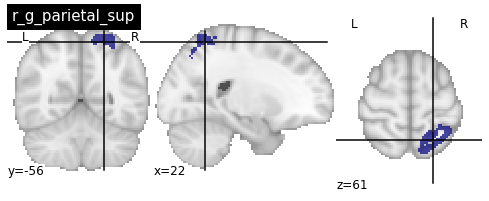

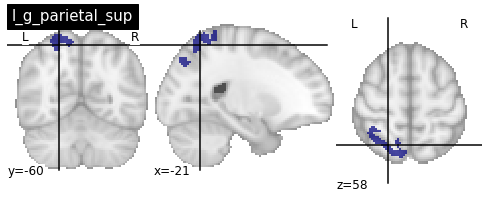

In [110]:
query = nl.new_symbol(name='query')
region_1 = nl.new_symbol(name='region_1')
region_2 = nl.new_symbol(name='region_2')

@nl.add_symbol
def region_volume(region: fe.ExplicitVBR) -> float:
    volume = (
        len(region.voxels) *
        float(np.product(np.abs(np.linalg.eigvals(region.affine[:-1, :-1]))))
    )
    return volume

res = nl.query(
    query(y, region_1),
    isSub('Gyrus of parietal lobe', x) & relation(y, x) &
    destrieux(y, region_1) & neurosynth_superior(region_2) &
    (region_volume(region_2) > 1500) &
    nl.symbols.overlapping(region_1, region_2)
)
for name, region in res.value:
    plotting.plot_roi(region.spatial_image(), title=name)

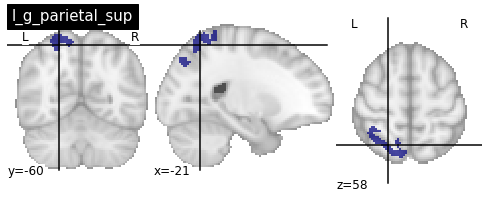

In [111]:
res2 = nl.query(
    query(y, region_1),
    #isSub('Gyrus of parietal lobe', x) & relation(y, x) &
    relation(y, 'Left superior parietal lobule') &
    destrieux(y, region_1) & neurosynth_superior(region_2) &
    (region_volume(region_2) > 1500) &
    nl.symbols.overlapping(region_1, region_2)
)
for name, region in res2.value:
    plotting.plot_roi(region.spatial_image(), title=name)

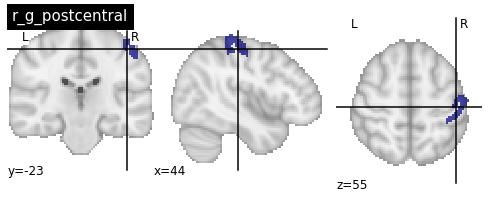

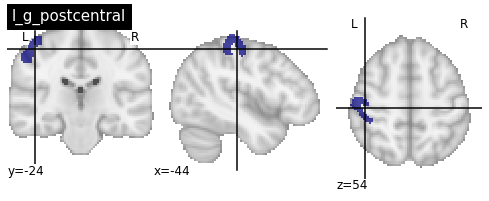

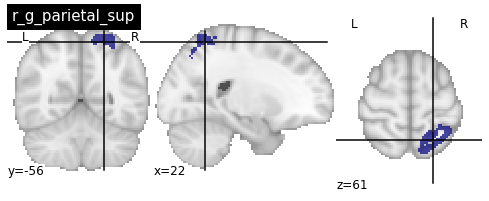

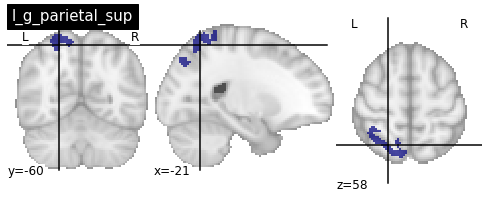

In [117]:
neurosynth_occipitotemporal = nl.load_neurosynth_term_regions(
    'occipitotemporal',
    name='neurosynth_occipitotemporal'
)

res3 = nl.query(
    query(y, region_1),
    destrieux(y, region_1) & neurosynth_occipitotemporal(region_2) &
    nl.symbols.overlapping(region_1, region_2)
)
for name, region in res3.value:
    plotting.plot_roi(region.spatial_image(), title=name)

In [116]:
res4 = nl.query(
    query(y, region_1),
    relation(y, 'Left occipitotemporal sulcus') &
    destrieux(y, region_1)
)
for name, region in res4.value:
    plotting.plot_roi(region.spatial_image(), title=name)

In [ ]:
dataset = Dataset('database.txt')
dataset.add_features('features.txt')

In [21]:
ids = dataset.get_studies(features='frontal lobe*', frequency_threshold=0.001)

In [22]:
len(ids)

271

In [23]:
ma = meta.MetaAnalysis(dataset, ids)
ma.save_results('.', 'frontal_lobe')

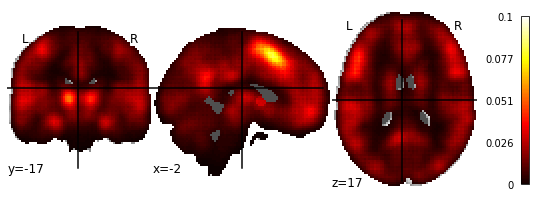

In [24]:
plotting.plot_stat_map('frontal_lobe_pA.nii.gz')

In [14]:
from neurolang.frontend.neurosynth_utils import NeuroSynthHandler

In [15]:
nsh = NeuroSynthHandler()
dataset = nsh.ns_load_dataset()
nsh = NeuroSynthHandler(ns_dataset=dataset)

In [27]:
import os
try:
    os.chdir(os.path.join(os.getcwd(), 'examples'))
    print(os.getcwd())
except:
    pass

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')


import nilearn
from nilearn import plotting
import nibabel as nib
import numpy as np

from neurolang import regions
from neurolang import region_solver

from neurolang import expressions
from neurolang import solver_datalog_naive as sdb
from neurolang import solver_datalog_extensional_db
from neurolang import expression_walker as ew
from neurolang.datalog_chase import DatalogChase


C_ = expressions.Constant
S_ = expressions.Symbol
Imp_ = sdb.Implication
Fact_ = sdb.Fact
Eb_ = expressions.ExpressionBlock


atlas_destrieux = nilearn.datasets.fetch_atlas_destrieux_2009()


image = nib.load(atlas_destrieux['maps'])
image_data = image.get_data()


region_dict = {}
for label, name in atlas_destrieux['labels']:
    if label == 0 or label == 42 or label == 117:
        continue
    r = regions.ExplicitVBR(np.transpose((image_data == label).nonzero()), image.affine, image_dim=image.shape)
    if r.voxels.shape[0] > 0:
        region_dict[name.decode('utf8')] = r
    

destrieux = sdb.Symbol('Destrieux')
destrieux_facts = [
    Fact_(destrieux(
        C_(name), 
        C_(region)
    ))
    for name, region in region_dict.items()
]


from typing import Any

class Datalog(
    region_solver.RegionSolver,
    dc.sdb.DatalogBasic,
    solver_datalog_extensional_db.ExtensionalDatabaseSolver,
    ew.ExpressionBasicEvaluator
):
    def function_lh(self, x: str) -> bool:
        return x.startswith('L ')
    
    def function_rh(self, x: str) -> bool:
        return x.startswith('R ')


superior_sts_l = S_('region_l_sts')
r = S_('r')
name = S_('name')

t1 = Imp_(
    S_('superior_sts_l')(name),
        destrieux(C_('L S_temporal_sup'), superior_sts_l) &
        S_('anatomical_superior_of')(r, superior_sts_l) &
        S_('lh')(name) & 
        destrieux(name, r)
)

datalog_program = Eb_(
    destrieux_facts + [
    t1,
])

dl = Datalog()
dl.walk(datalog_program);

dc = DatalogChase(dl)
solution = dc.build_chase_solution()

rsbv = ew.ReplaceExpressionsByValues({})
result = rsbv.walk(solution['superior_sts_l'])
result

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/numpy/lib/npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


frozenset({('L G_and_S_cingul-Mid-Ant',),
           ('L G_and_S_cingul-Mid-Post',),
           ('L G_and_S_paracentral',),
           ('L G_and_S_subcentral',),
           ('L G_cingul-Post-dorsal',),
           ('L G_cuneus',),
           ('L G_front_middle',),
           ('L G_front_sup',),
           ('L G_occipital_sup',),
           ('L G_parietal_sup',),
           ('L G_postcentral',),
           ('L G_precentral',),
           ('L G_precuneus',),
           ('L S_central',),
           ('L S_cingul-Marginalis',),
           ('L S_circular_insula_sup',),
           ('L S_front_inf',),
           ('L S_front_sup',),
           ('L S_interm_prim-Jensen',),
           ('L S_intrapariet_and_P_trans',),
           ('L S_parieto_occipital',),
           ('L S_postcentral',),
           ('L S_precentral-inf-part',),
           ('L S_precentral-sup-part',),
           ('L S_subparietal',)})